Fitting 3 folds for each of 16 candidates, totalling 48 fits
Validation set -> MSE: 31.481, MAE: 4.872, R²: -0.013


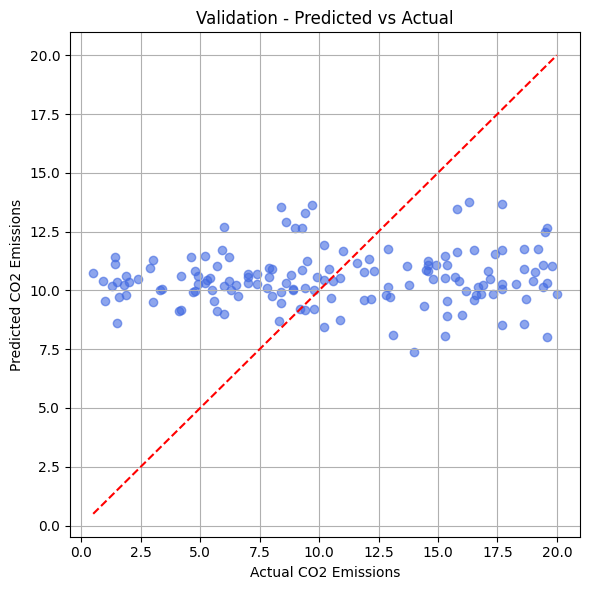

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


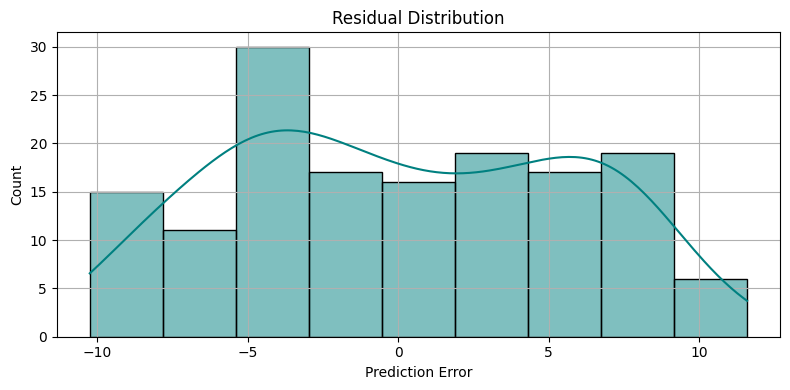

Test set -> MSE: 33.894, MAE: 4.971, R²: -0.070


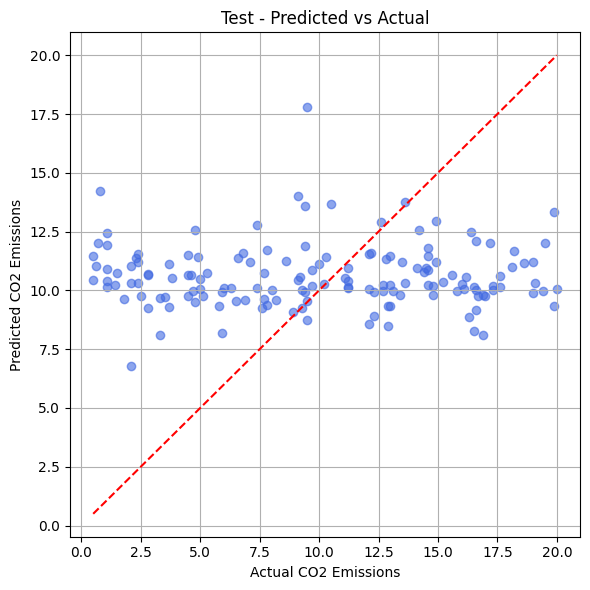

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


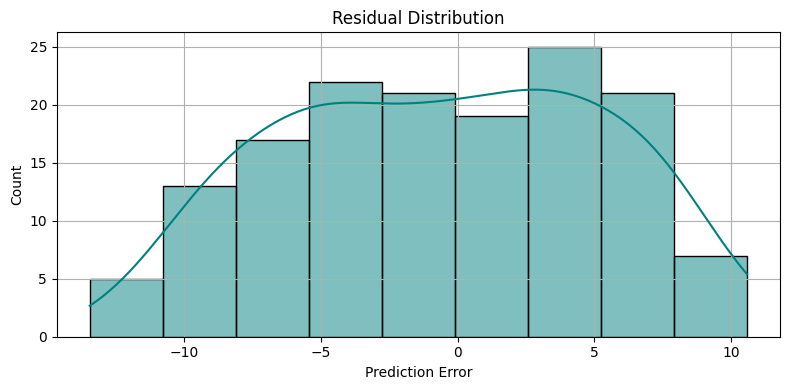

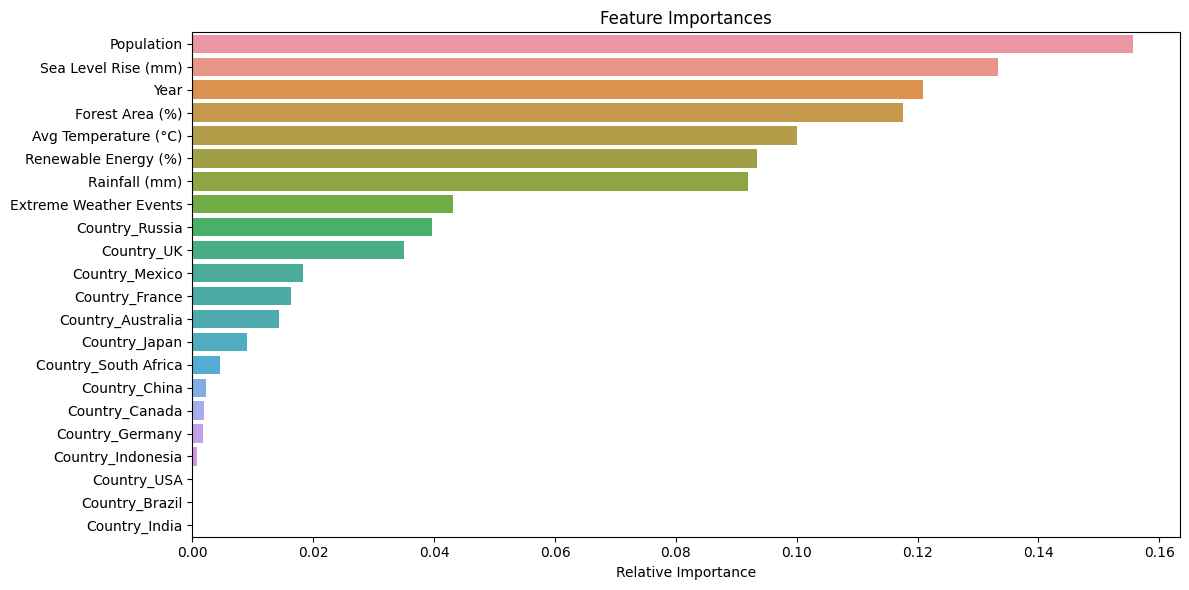

✅ Tuned model saved to 'gb_co2_model_tuned.pkl'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Load dataset
file_path = "/kaggle/input/climatechangedataset/climate_change_dataset.csv"
df = pd.read_csv(file_path)


df_encoded = pd.get_dummies(df, columns=['Country'], drop_first=True)


X = df_encoded.drop(['CO2 Emissions (Tons/Capita)'], axis=1)
y = df_encoded['CO2 Emissions (Tons/Capita)']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


def plot_feature_importances(model, X):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns[indices]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances[indices], y=features)
    plt.title('Feature Importances')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

# Predicted vs Actual
def plot_predictions(y_true, y_pred, title=''):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, color='royalblue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual CO2 Emissions")
    plt.ylabel("Predicted CO2 Emissions")
    plt.title(title or 'Predicted vs Actual')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Residual plot
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, kde=True, color='teal')
    plt.title("Residual Distribution")
    plt.xlabel("Prediction Error")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Evaluate and plot
def evaluate_with_plots(name, X_split, y_split):
    preds = best_model.predict(X_split)
    mse = mean_squared_error(y_split, preds)
    mae = mean_absolute_error(y_split, preds)
    r2 = r2_score(y_split, preds)
    print(f"{name} set -> MSE: {mse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
    plot_predictions(y_split, preds, title=f"{name} - Predicted vs Actual")
    plot_residuals(y_split, preds)

# Evaluate model
evaluate_with_plots("Validation", X_val, y_val)
evaluate_with_plots("Test", X_test, y_test)

plot_feature_importances(best_model, X)

# Save the model
joblib.dump(best_model, 'gb_co2_model_tuned.pkl')
print("✅ Tuned model saved to 'gb_co2_model_tuned.pkl'")

